In [5]:
import re
import pickle 
import os 
import glob
from tqdm import tqdm
import pympi.Elan 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch 
from transformers import BertModel 
from transformers import BertJapaneseTokenizer

import utils

from transformers import logging
logging.set_verbosity_error()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
feature_path = '../data/Hazumi_features/'

# オークナイザーの読み込み
tokenizer = BertJapaneseTokenizer.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking"
)

# 学習済みモデルの読み込み
model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking").to(device)


def preprocess(text):
    """ 
    フィラー記号(F *)，|の除去
    """
    text = re.sub('\([^)]*\)', '', text)
    text = text.replace('|', '')

    return text


def embedding(sentences):
    # 前処理

    sentences = [preprocess(text) for text in sentences]

    # BERTトークン化
    encoded = tokenizer.batch_encode_plus(
        sentences, padding=True, add_special_tokens=True
    )


    # BERTトークンID列を抽出
    input_ids = torch.tensor(encoded["input_ids"], device=device) 

    # BERTの最大許容トークン数が512なので超える場合は切り詰める
    input_ids = input_ids[:, :512] 

    with torch.no_grad():
        outputs = model(input_ids) 

    # 最終層の隠れ状態ベクトルを取得
    last_hidden_states = outputs[0] 

    # [CLS]トークンの単語ベクトルを抽出
    vecs = last_hidden_states[:, 0, :]

    return vecs.tolist()


def eaf_to_df( eaf: pympi.Elan.Eaf ) -> pd.DataFrame:
    tier_names = list( eaf.tiers.keys() )

    def timeslotid_to_time( timeslotid: str ) -> float:
        return eaf.timeslots[ timeslotid ] / 1000

    def parse( tier_name: str, tier: dict ) -> pd.DataFrame:
        values = [ (key,) + value[:-1] for key, value in tier.items() ]
        df = pd.DataFrame( values, columns=[ "id", "start", "end", "transcription"] )

        df["start"] = df["start"].apply( timeslotid_to_time )
        df["end"] = df["end"].apply( timeslotid_to_time )
        df["ID"] = df.apply( lambda x: f"{tier_name}-{x.name}", axis=1 )
        df = df.reindex( columns=["ID", "start", "end", "transcription"] )

        return df

    dfs = [ parse(tier_name=name, tier=eaf.tiers[name][0]) for name in tier_names ]
    df = pd.concat( dfs )
    df = df.sort_values( "start" )
    df = df.reset_index( drop=True )
    return df

def extract_sentence(version, filename, start):
    res = []
    sys_res = []
    raw_sentence = []
    raw_sys_sentence = []
    src = f'../data/Hazumi/Hazumi{version}/elan/' + filename + '.eaf' 

    eaf = pympi.Elan.Eaf(src) 
    df = eaf_to_df(eaf) 

    df['start'] = (df['start'] * 1000).astype(int)


    for time in start:
        sentence = df[(df['start'] == time) & (df['ID'].str.contains('user'))]['transcription'].values.tolist()
        sys_sentence = df[(df['start'] == time) & (df['ID'].str.contains('sys'))]['transcription'].values.tolist()
        if len(sentence) == 0:
            sentence = ['']
        if len(sys_sentence) == 0:
            sys_sentence = ['']
        raw_sentence.append(sentence) 
        raw_sys_sentence.append(sys_sentence)
        sentence = embedding(sentence)
        sys_sentence = embedding(sys_sentence)
        res.append(sentence[0])
        sys_res.append(sys_sentence[0])

    return res

def extract_sentence_v2(version, filename, start):
    res = []
    sys_res = []
    raw_sentence = []
    raw_sys_sentence = []
    src = f'../data/Hazumi/Hazumi{version}/elan/' + filename + '.eaf' 

    eaf = pympi.Elan.Eaf(src) 
    df = eaf_to_df(eaf) 

    df['start'] = (df['start'] * 1000).astype(int)


    for time in start:
        sentence = df[(df['start'] == time) & (df['ID'].str.contains('user'))]['transcription'].values.tolist()
        sys_sentence = df[(df['start'] == time) & (df['ID'].str.contains('sys'))]['transcription'].values.tolist()
        if len(sentence) == 0:
            sentence = ['']
        if len(sys_sentence) == 0:
            sys_sentence = ['']
        raw_sentence.append(sentence) 
        raw_sys_sentence.append(sys_sentence)
        sentence = embedding(sentence)
        sys_sentence = embedding(sys_sentence)
        res.append(sentence[0])
        sys_res.append(sys_sentence[0])

    return res, raw_sentence


def personality_binarization(x, vid):
    """
    性格特性スコアを2クラスに分類
    """
    binary = {}
    df = pd.DataFrame.from_dict(x, orient='index')

    df = (df >= 0) * 1

    for id in vid:
        binary[id] = df.loc[id, :].tolist()

    return binary

def get_personality(hazumiversion, filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    if hazumiversion == "1911":
        filepath = "../data/Hazumi/Hazumi1911/questionnaire/1911questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=4, header=1, index_col=0)
    elif hazumiversion == "2010":
        filepath = "../data/Hazumi/Hazumi2010/questionnaire/questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=3, header=1, index_col=0)
    elif hazumiversion == "2012":
        filepath = "../data/Hazumi/Hazumi2012/questionnaire/questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=3, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[0] + (8 - data[5]), (8-data[1]) + data[6], data[2] + (8-data[7]), data[3] + (8-data[8]), data[4] + (8-data[9])]

def calc_big5(df, filename):
    data = df.loc[filename, :].values
    return [data[0] + (8 - data[5]), (8-data[1]) + data[6], data[2] + (8-data[7]), data[3] + (8-data[8]), data[4] + (8-data[9])]

def get_third_personality(version, filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    if version == "1911":
        file_path = '../data/Hazumi/Hazumi1911/questionnaire/220818thirdbigfive-Hazumi1911.xlsx'
        df = pd.read_excel(file_path, sheet_name=5, header=1, index_col=0)
        data = df.loc[filename].values.tolist()
        return [data[5], data[13], data[21], data[29], data[37]]
    elif version == "2010":
        file_path = '../data/Hazumi/Hazumi2010/questionnaire/questionnaires-3rdparty-personality.xlsx'
    elif version == '2012':
        file_path = '../data/Hazumi/Hazumi2012/questionnaire/questionnaires-3rdparty-personality.xlsx'
    
    data = np.array([0, 0, 0, 0, 0])
    for i in range(5):
        df = pd.read_excel(file_path, sheet_name=i, header=1, index_col=0)
        data += calc_big5(df, filename)
    data = data / 5 
    return data.tolist()


/home/ryoyanagimoto/anaconda3/envs/personality/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 1712
version = "1712"
dumpfile_path = f'../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

text = {}
audio = {}
visual = {} 

SP = {}
TP = {}

SS_raw = {} 
SS_binary = {}
SS_ternary = {}
TS_raw = {}
TS_binary = {}

TS_ternary = {}

vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)[ms]'].values.tolist()

    vid.append(filename)
    text[filename] = extract_sentence(version, filename, start)
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    # SP[filename] = get_personality(version, filename)
    # TP[filename] = get_third_personality(version, filename)

    # row
    # SS[filename] = df.loc[:, 'SS'].astype(int).values.tolist()
    TS_raw[filename] = (df.loc[:, 'TS1':'TS5'].mean(axis='columns')).values.tolist()
    # binary
    # SS[filename] = (df.loc[:, 'SS'] > 4.0).astype(int).values.tolist()
    TS_binary[filename] = (df.loc[:, 'TS1':'TS5'].mean(axis='columns') >= 4.0).astype(int).values.tolist()
    # ternary
    # SS[filename] = df.loc[:, 'SS_ternary'].astype(int).values.tolist()
    TS_ternary[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()

# SP_scaled = utils.dict_standardize(SP, vid)
# SP_binary = personality_binarization(SP_scaled, vid)
# SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)
with open(feature_path + f'Hazumi{version}_features.pkl', mode='wb') as f:
    pickle.dump((SS_raw, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
# 1902
version = "1902"
dumpfile_path = f'../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

text = {}
audio = {}
visual = {} 

SP = {}
TP = {}

SS_raw = {}
TS_raw = {}

SS_binary = {}
TS_binary = {}

SS_ternary = {}
TS_ternary = {}

vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)[ms]'].values.tolist()

    vid.append(filename)
    text[filename] = extract_sentence(version, filename, start)
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    # SP[filename] = get_personality(version, filename)
    # TP[filename] = get_third_personality(version, filename)

    # row
    SS_raw[filename] = df.loc[:, 'SS'].astype(int).values.tolist()
    TS_raw[filename] = df.loc[:, 'TS1':'TS5'].mean(axis='columns').values.tolist()
    # binary
    SS_binary[filename] = (df.loc[:, 'SS'] >= 4.0).astype(int).values.tolist()
    TS_binary[filename] = (df.loc[:, 'TS1':'TS5'].mean(axis='columns') >= 4.0).astype(int).values.tolist()
    # ternary
    SS_ternary[filename] = df.loc[:, 'SS_ternary'].astype(int).values.tolist()
    TS_ternary[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()

# SP_scaled = utils.dict_standardize(SP, vid)
# SP_binary = personality_binarization(SP_scaled, vid)
# SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)
with open(feature_path + f'Hazumi{version}_features.pkl', mode='wb') as f:
    pickle.dump((SS_raw, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
# 1911
version = "1911"
dumpfile_path = f'../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

text = {}
audio = {}
visual = {} 

SP = {}
TP = {}

SS_raw = {}
TS_raw = {}

SS_binary = {}
TS_binary = {}

SS_ternary = {}
TS_ternary = {}

vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)[ms]'].values.tolist()

    vid.append(filename)
    text[filename] = extract_sentence(version, filename, start)
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    SP[filename] = get_personality(version, filename)
    TP[filename] = get_third_personality(version, filename)

    # row
    SS_raw[filename] = df.loc[:, 'SS'].astype(int).values.tolist()
    # TS[filename] = df.loc[:, 'TS1':'TS5'].values.tolist()
    TS_raw[filename] = df.loc[:, 'TS1':'TS5'].mean(axis='columns').values.tolist()
    # binary
    SS_binary[filename] = (df.loc[:, 'SS'] >= 4.0).astype(int).values.tolist()
    TS_binary[filename] = (df.loc[:, 'TS1':'TS5'].mean(axis='columns') >= 4.0).astype(int).values.tolist()
    # ternary
    SS_ternary[filename] = df.loc[:, 'SS_ternary'].astype(int).values.tolist()
    TS_ternary[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()

# SP_scaled = utils.dict_standardize(SP, vid)
# SP_binary = personality_binarization(SP_scaled, vid)
# SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)
with open(feature_path + f'Hazumi{version}_features.pkl', mode='wb') as f:
    pickle.dump((SS_raw, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
# 2010
version = "2010"
dumpfile_path = f'../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

text = {}
audio = {}
visual = {} 

SP = {}
TP = {}

# SS = {}
SS_raw = {} 
SS_binary = {}
SS_ternary = {}
TS_raw = {}
TS_binary = {}
TS_ternary = {}

vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)'].values.tolist()

    vid.append(filename)
    text[filename] = extract_sentence(version, filename, start)
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis\n'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    SP[filename] = get_personality(version, filename)
    TP[filename] = get_third_personality(version, filename)

    # row
    TS_raw[filename] = df.loc[:, 'TS1':'TS3'].mean(axis='columns').values.tolist()
    # binary
    TS_binary[filename] = (df.loc[:, 'TS1':'TS3'].mean(axis='columns') >= 4.0).astype(int).values.tolist()
    # ternary
    # TS_ternary[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()
    # TS[filename] = (df.loc[:, 'TS1':'TS3'].mean(axis='columns') >= 4.0).astype(int).values.tolist()

for id, values in TS_raw.items():
    ts_ternary = []
    for ts in values:
        if ts > 4.5:
            ts_ternary.append(2)
        elif ts >= 3.5:
            ts_ternary.append(1)
        else:
            ts_ternary.append(0)
    TS_ternary[id] = ts_ternary

# SP_scaled = utils.dict_standardize(SP, vid)
# SP_binary = personality_binarization(SP_scaled, vid)

# SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)
with open(feature_path + f'Hazumi{version}_features.pkl', mode='wb') as f:
    pickle.dump((SS_raw, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
version = "2012"
dumpfile_path = f'../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

text = {}
audio = {}
visual = {} 

SP = {}
TP = {}

SS = {}
SS_binary = {} 
SS_ternary = {}
TS_raw = {}
TS_binary = {}
TS_ternary = {}

vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)'].values.tolist()

    vid.append(filename)
    text[filename] = extract_sentence(version, filename, start)
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis\n'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    SP[filename] = get_personality(version, filename)
    TP[filename] = get_third_personality(version, filename)

    # row
    TS_raw[filename] = df.loc[:, 'TS1':'TS3'].mean(axis='columns').round(2).values.tolist()
    # binary
    TS_binary[filename] = (df.loc[:, 'TS1':'TS3'].mean(axis="columns") >= 4.0).astype(int).values.tolist()
    # ternary
    # TS_ternary[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()

for id, values in TS_raw.items():
    ts_ternary = []
    for ts in values:
        if ts > 4.5:
            ts_ternary.append(2)
        elif ts >= 3.5:
            ts_ternary.append(1)
        else:
            ts_ternary.append(0)
    TS_ternary[id] = ts_ternary
    
# SP_scaled = utils.dict_standardize(SP, vid)
# SP_binary = personality_binarization(SP_scaled, vid)

# SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)
with open(feature_path + f'Hazumi{version}_features.pkl', mode='wb') as f:
    pickle.dump((SS, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
# All(raw)
with open('../data/Hazumi_features/Hazumi1712_features.pkl', mode='rb') as f:
    data1712 = pickle.load(f, encoding='utf-8')
    
with open('../data/Hazumi_features/Hazumi1902_features.pkl', mode='rb') as f:
    data1902 = pickle.load(f, encoding='utf-8')

with open('../data/Hazumi_features/Hazumi1911_features.pkl', mode='rb') as f:
    data1911 = pickle.load(f, encoding='utf-8')

with open('../data/Hazumi_features/Hazumi2010_features.pkl', mode='rb') as f:
    data2010 = pickle.load(f, encoding='utf-8')

with open('../data/Hazumi_features/Hazumi2012_features.pkl', mode='rb') as f:
    data2012 = pickle.load(f, encoding='utf-8')

data = {
    '1712': data1712,
    '1902': data1902,
    '1911': data1911,
    '2010': data2010, 
    '2012': data2012
}

def data_augmentation(versions):
    SS, SS_binary, SS_ternary, TS, TS_binary, TS_ternary, SP, TP = {}, {}, {}, {}, {}, {}, {}, {}
    text, audio, visual, vid = {}, {}, {}, []
    for version in versions:
        SS.update(data[version][0])
        SS_binary.update(data[version][1])
        SS_ternary.update(data[version][2])
        TS.update(data[version][3])
        TS_binary.update(data[version][4])
        TS_ternary.update(data[version][5])
        SP.update(data[version][6])
        TP.update(data[version][7])
        text.update(data[version][8])
        audio.update(data[version][9])
        visual.update(data[version][10])
        vid.extend(data[version][11])
    return SS, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid

SS, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid = data_augmentation(['1712', '1902', '1911', '2010', '2012'])

with open(feature_path + 'Hazumiall_features.pkl', mode='wb') as f:
    pickle.dump((SS, TS_raw, TS_binary, TS_ternary, SP, TP, text, audio, visual, vid), f)

In [ ]:
version = "2012"
with open(f'../data/Hazumi_features/Hazumi{version}_features.pkl', mode='rb') as f:
    SS, SS_binary, SS_ternary, TS, TS_binary, TS_ternary, SP, TP, Text, Audio, Visual, vid \
        = pickle.load(f, encoding='utf-8')

age = [0, 0, 0, 0, 0, 0]
gender = [0, 0]
E, A, C, N, O = [], [], [], [], []
for id in vid:
    if id[4] == 'F':
        gender[0] += 1
    else:
        gender[1] += 1
    age[int(id[5])-2] += 1
    E.append(TP[id][0])
    A.append(TP[id][1])
    C.append(TP[id][2])
    N.append(TP[id][3])
    O.append(TP[id][4])

print(gender)
print(age)
print(sum(age))

count = [0, 0]
for e in O:
    if e < 8:
        count[0] += 1
    else:
        count[1] += 1
count
# p_data = []
# for id, data in TP.items():
#     p_data.append(data)

# print(p_data)
# from sklearn import preprocessing

# scaler = preprocessing.StandardScaler() 

# p_data = scaler.fit_transform(p_data)
# print(p_data)

# p_df = pd.DataFrame(p_data)

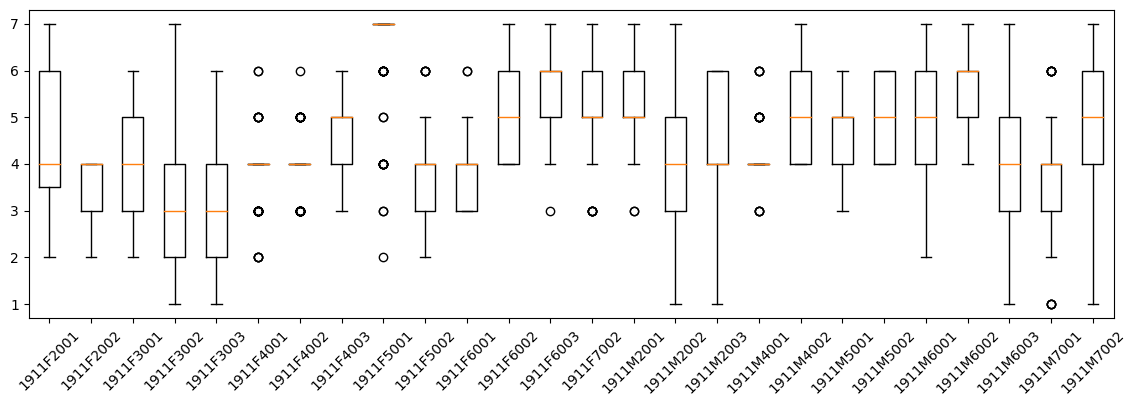

0.835223100593629
0.22000416468969503


[[2, 3, 3, 2, 3, 1], [3, 0, 2, 2, 3, 2]]

In [44]:
import matplotlib.pyplot as plt 
import statistics
train_version = "1911"
path = f'../data/Hazumi_features/Hazumi{train_version}_features.pkl'
SS_raw, SS_binary, SS_ternary, TS_raw, TS_binary, TS_ternary, _, TP, _, _, _, vid = pickle.load(open(path, 'rb'), encoding='utf-8')

SS, ss, TS, ts = [], [], []
for id in vid:
    SS.append(SS_raw[id])
    TS.append(TS_raw[id])
    ss.append(sum(SS_raw[id]) / len(SS_raw[id]))
    ts.append(sum(TS_raw[id]) / len(TS_raw[id]))
fig, ax = plt.subplots(figsize=(14,4)) 
bp = ax.boxplot(SS)
ax.set_xticklabels(vid, rotation=45)
plt.show()
print(statistics.pstdev(ss))
print(statistics.pstdev(ts))

count = [[0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0]]
for id in vid:
    gender = id[4]
    age = int(id[5])
    if gender == 'F':
        count[0][age-2] += 1
    else:
        count[1][age-2] += 1
count

In [20]:
modals = ['ta', 'tv', 'av', 'tav']
pmodes = list(range(0, 9))
seeds = list(range(0, 5))

for seed in seeds:
    for pmode in pmodes:
        for modal in modals:
            cmd = f'python late_fusion.py --ss --modal {modal} --pmode {pmode} --seed {seed}  --save_results'
            print(cmd)

python late_fusion.py --ss --modal ta --pmode 0 --seed 0  --save_results
python late_fusion.py --ss --modal tv --pmode 0 --seed 0  --save_results
python late_fusion.py --ss --modal av --pmode 0 --seed 0  --save_results
python late_fusion.py --ss --modal tav --pmode 0 --seed 0  --save_results
python late_fusion.py --ss --modal ta --pmode 1 --seed 0  --save_results
python late_fusion.py --ss --modal tv --pmode 1 --seed 0  --save_results
python late_fusion.py --ss --modal av --pmode 1 --seed 0  --save_results
python late_fusion.py --ss --modal tav --pmode 1 --seed 0  --save_results
python late_fusion.py --ss --modal ta --pmode 2 --seed 0  --save_results
python late_fusion.py --ss --modal tv --pmode 2 --seed 0  --save_results
python late_fusion.py --ss --modal av --pmode 2 --seed 0  --save_results
python late_fusion.py --ss --modal tav --pmode 2 --seed 0  --save_results
python late_fusion.py --ss --modal ta --pmode 3 --seed 0  --save_results
python late_fusion.py --ss --modal tv --pmode 3 

In [ ]:
modals = ['ta', 'tv', 'av', 'tav']
pmodes = list(range(0, 11))
seeds = list(range(5))

for seed in seeds:
    for pmode in pmodes:
        for modal in modals:
            cmd = f'python multi_modal.py --modal {modal} --pmode {pmode} --seed {seed} --results_save'
            print(cmd)